In [9]:
!pip install xgboost
!pip install shap


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import yeojohnson
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split, GridSearchCV
from DensityAwareClustering import DensityAwareClustering
import shap

In [11]:
datapath = "/Users/halvornedrebo/Documents/Programmering/INFO381/data/"

In [ ]:
#data = pd.read_csv('data/fraud.csv', index_col=0)


In [ ]:
le = LabelEncoder()


def clean_data(filename):

    print("Importing data...")
    data = pd.read_csv(datapath+filename, index_col=0)

    dac = DensityAwareClustering(eps=0.5, min_samples=max(5, int(len(data) * 0.01)))

    print("splitting time columns...")
    data["trans_date_trans_time"] = pd.to_datetime(data["trans_date_trans_time"])

    data['trans_minute'] = data['trans_date_trans_time'].dt.minute
    data['trans_hour'] = data['trans_date_trans_time'].dt.hour
    data['trans_day'] = data['trans_date_trans_time'].dt.day
    data['trans_month'] = data['trans_date_trans_time'].dt.month
    data['trans_year'] = data['trans_date_trans_time'].dt.year
    data['trans_dayofweek'] = data['trans_date_trans_time'].dt.dayofweek

    data["dob"] = pd.to_datetime(data["dob"])
    data["dob_day"] = data["dob"].dt.day
    data["dob_month"] = data["dob"].dt.month
    data["dob_year"] = data["dob"].dt.year


    print("Handling skewing...")
    data["amt"] = np.log(data["amt"])
    data["city_pop"] = np.log(data["city_pop"])
    
    quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
    data["dob_year"] = quantile_transformer.fit_transform(data["dob_year"].values.reshape(-1, 1)).flatten()


    print("Cyclically encoding features...")
    data["trans_minute_sin"] = np.sin(2*np.pi *data["trans_minute"]/60)
    data["trans_minute_cos"] = np.cos(2*np.pi *data["trans_minute"]/60)
    data["trans_hour_sin"] = np.sin(2*np.pi *data["trans_hour"]/24)
    data["trans_hour_cos"] = np.cos(2*np.pi *data["trans_hour"]/24)
    data["trans_day_sin"] = np.sin(2*np.pi *data["trans_day"]/31)
    data["trans_day_cos"] = np.cos(2*np.pi *data["trans_day"]/31)
    data["trans_month_sin"] = np.sin(2*np.pi *data["trans_month"]/12)
    data["trans_month_cos"] = np.cos(2*np.pi *data["trans_month"]/12)
    data["trans_dayofweek_sin"] = np.sin(2*np.pi *data["trans_dayofweek"]/7)
    data["trans_dayofweek_cos"] = np.cos(2*np.pi *data["trans_dayofweek"]/7)
    data["dob_day_sin"] = np.sin(2*np.pi *data["dob_day"]/31)
    data["dob_day_cos"] = np.cos(2*np.pi *data["dob_day"]/31)
    data["dob_month_sin"] = np.sin(2*np.pi *data["dob_month"]/12)
    data["dob_month_cos"] = np.cos(2*np.pi *data["dob_month"]/12)

    data, centroids = dac.find_natural_clusters(data)

    # uncomment if you want to visualize the clustering results
    dac.visualize_clusters(data, centroids)

    data = data.drop(["trans_minute", "trans_hour", "trans_day", "trans_month", 
                      "trans_dayofweek", "dob_day", "dob_month", "long", "merch_long",
                      "lat", "merch_lat", "cc_num", "unix_time", "trans_date_trans_time",
                      "first", "last", "dob", "zip",
                      "trans_num"], axis=1)
    
    cat_data = data.select_dtypes(include=["object"])

    print("Encoding categorical features...")
    for col in cat_data.columns:
        data[col] = le.fit_transform(data[col])

    tobnormalized = ["amt", "city_pop", "trans_year",
                     "merchant", "city", "state", "category",
                     "street", "job",
                     ]

    scaler = StandardScaler()

    print("Scaling features...")
    for col in tobnormalized:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1)).flatten()
        
    return data

In [ ]:
data = clean_data("fraud.csv")  

Importing data...
splitting time columns...
Handling skewing...
Cyclically encoding features...
Filtering clusters based on density and size...
adding distances
Encoding categorical features...


In [103]:
data.dtypes

merchant                   float64
category                   float64
amt                        float64
gender                     float64
street                     float64
city                       float64
state                      float64
city_pop                   float64
job                        float64
is_fraud                     int64
trans_year                   int64
dob_year                   float64
trans_minute_sin           float64
trans_minute_cos           float64
trans_hour_sin             float64
trans_hour_cos             float64
trans_day_sin              float64
trans_day_cos              float64
trans_month_sin            float64
trans_month_cos            float64
trans_dayofweek_sin        float64
trans_dayofweek_cos        float64
dob_day_sin                float64
dob_day_cos                float64
dob_month_sin              float64
dob_month_cos              float64
merchant_buyer_distance    float64
merchant_cluster_id          int16
buyer_cluster_id    

In [69]:

X = data.drop("is_fraud", axis=1)
y = data["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
model = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, device="cuda")

model.fit(X_train, y_train)

/Users/halvornedrebo/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:55:05] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [71]:
y_pred = model.predict(X_test)
xgb_rmse = np.sqrt(MSE(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

print(f"RMSE: {xgb_rmse:.2f}")
print(classification_report(y_test, y_pred))
print(cm)

RMSE: 0.05
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368526
           1       0.87      0.60      0.71      1953

    accuracy                           1.00    370479
   macro avg       0.94      0.80      0.86    370479
weighted avg       1.00      1.00      1.00    370479

[[368357    169]
 [   780   1173]]


<Figure size 1000x800 with 0 Axes>

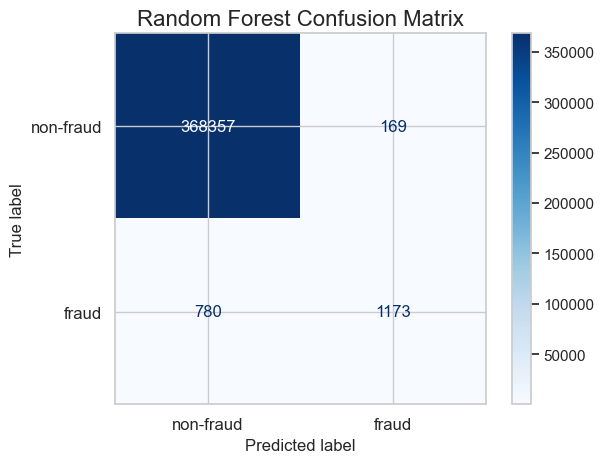

In [72]:
class_names = ["non-fraud", "fraud"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig("confusion_matrix.png", bbox_inches='tight')

In [73]:
explainer = shap.TreeExplainer(model)
explanation = explainer(X_test)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - y_pred).max()

17.184532165527344

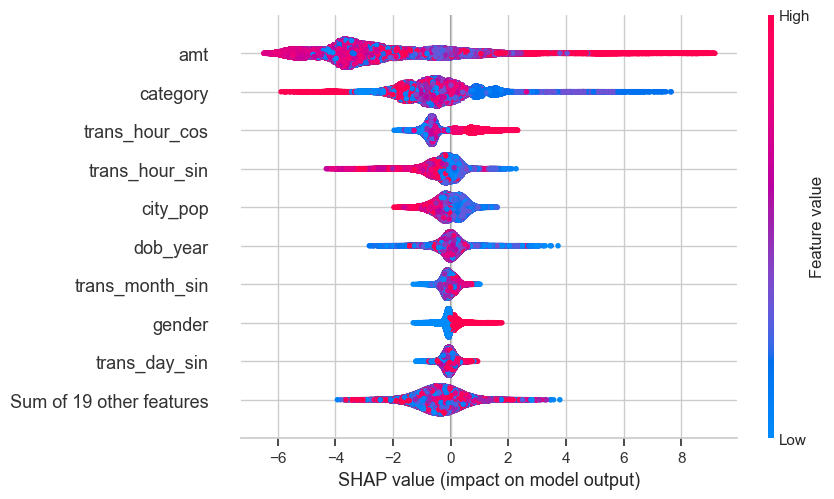

In [21]:
shap.plots.beeswarm(explanation)

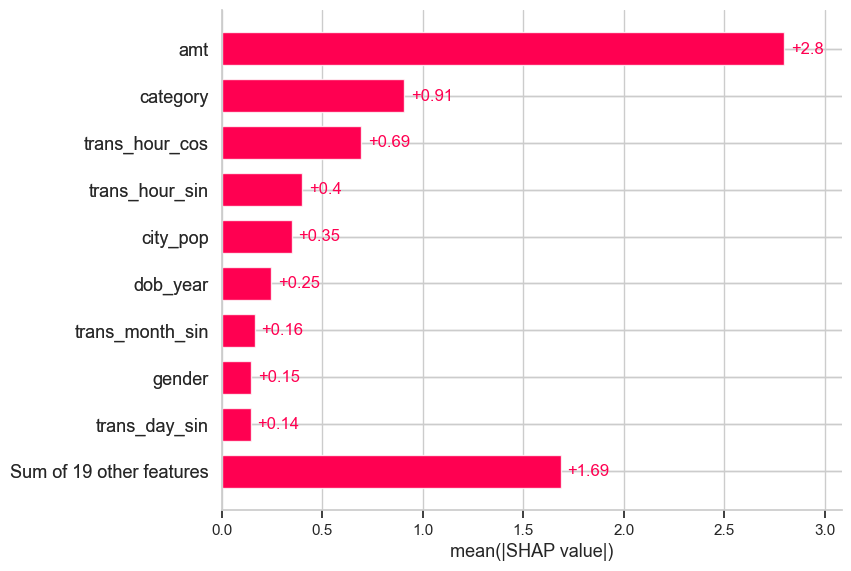

In [22]:
shap.plots.bar(explanation)

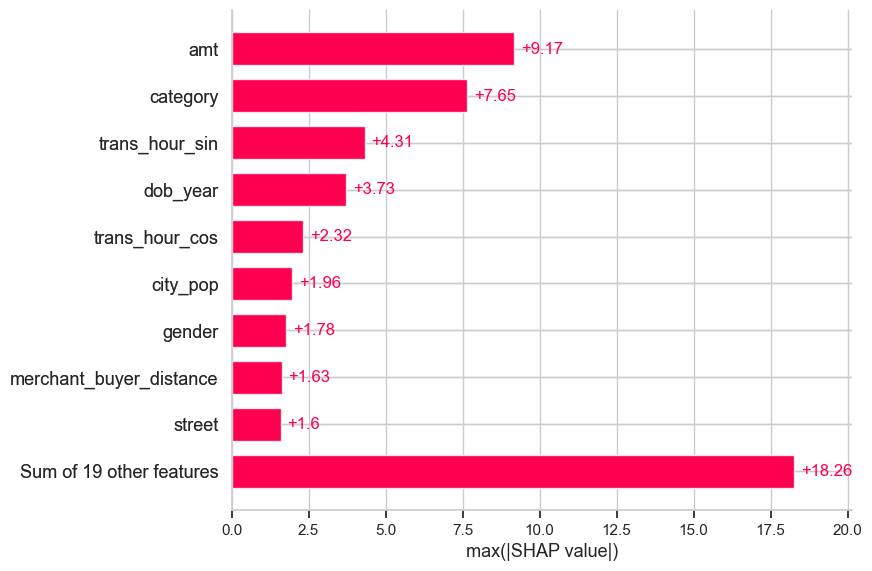

In [23]:
shap.plots.bar(explanation.abs.max(0))

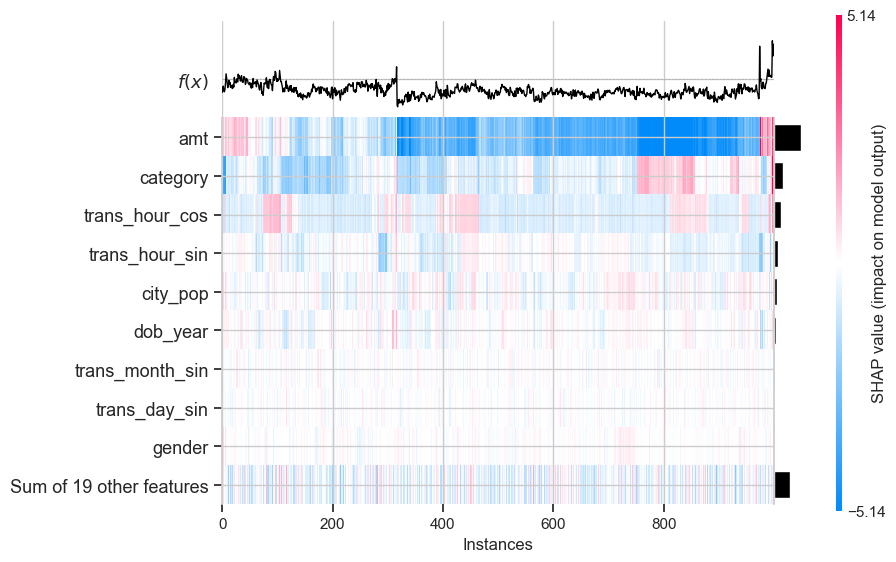

<AxesSubplot:xlabel='Instances'>

In [24]:
shap.plots.heatmap(explanation[:1000])

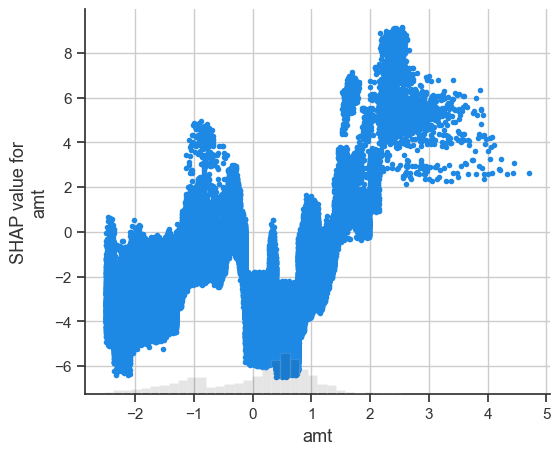

In [25]:
shap.plots.scatter(explanation[:, "amt"])

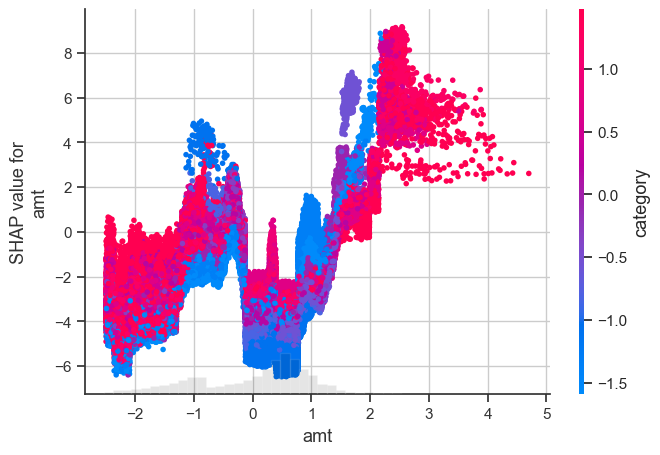

In [26]:
shap.plots.scatter(explanation[:, "amt"], color=explanation[:, "category"])

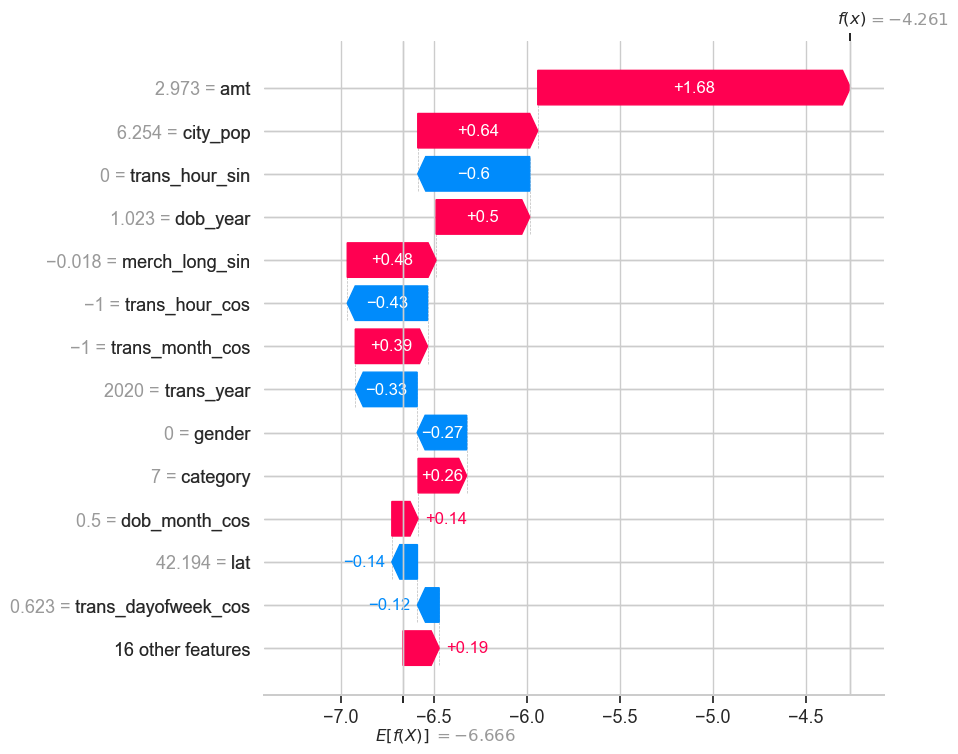

In [ ]:
shap.plots.waterfall(explanation[5], max_display=14)

In [32]:
!pip install dice-ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.9 MB/s eta 0:00:0000:0100:01


In [33]:
import dice_ml
from dice_ml.utils import helpers

In [39]:
data.columns

Index(['merchant', 'category', 'amt', 'gender', 'street', 'city', 'state',
       'city_pop', 'job', 'is_fraud', 'trans_year', 'dob_year',
       'trans_minute_sin', 'trans_minute_cos', 'trans_hour_sin',
       'trans_hour_cos', 'trans_day_sin', 'trans_day_cos', 'trans_month_sin',
       'trans_month_cos', 'trans_dayofweek_sin', 'trans_dayofweek_cos',
       'dob_day_sin', 'dob_day_cos', 'dob_month_sin', 'dob_month_cos',
       'merchant_buyer_distance', 'merchant_cluster_id', 'buyer_cluster_id'],
      dtype='object')

In [93]:
categorical = X[["amt", "city_pop", "trans_year","merchant", "city", "state", "category","street", "job"]]

print(categorical.head)

<bound method NDFrame.head of              amt   city_pop  trans_year  merchant  city  state  category  \
0       1.603420   8.159089        2019       NaN   NaN    NaN       NaN   
1       4.674976   5.003946        2019       NaN   NaN    NaN       NaN   
2       5.394127   8.331827        2019       NaN   NaN    NaN       NaN   
3       3.806662   7.569928        2019       NaN   NaN    NaN       NaN   
4       3.736717   4.595120        2019       NaN   NaN    NaN       NaN   
...          ...        ...         ...       ...   ...    ...       ...   
555714  3.778949   6.251904        2020       NaN   NaN    NaN       NaN   
555715  4.717069  10.266010        2020       NaN   NaN    NaN       NaN   
555716  4.464528   8.211754        2020       NaN   NaN    NaN       NaN   
555717  2.078191   4.859812        2020       NaN   NaN    NaN       NaN   
555718  3.641001  11.661354        2020       NaN   NaN    NaN       NaN   

        street  job  
0          NaN  NaN  
1          Na

In [91]:
from dice_ml import Dice, Data, Model

df_dice = X.copy()
df_dice["is_fraud"] = y

columns = X.columns.tolist()
categorical = ["amt", "city_pop", "trans_year","merchant", "city", "state", "category","street", "job"]

continuous = list(set(columns)-set(categorical))

data_dice = Data(
    dataframe=df_dice,
    continuous_features=continuous,  # all features are numeric now
    categorical_features=["amt", "city_pop", "trans_year","merchant", "city", "state", "category","street", "job"],
    outcome_name="is_fraud"
)


In [80]:
from dice_ml import Model

model_dice = Model(model=model, backend="sklearn")

In [81]:
from dice_ml import Dice

d_explainer = Dice(data_dice, model_dice, method='genetic')

In [ ]:


query_instance = X_test.iloc[[2]]  # keep as DataFrame


cf = d_explainer.generate_counterfactuals(query_instance, total_CFs=3, desired_class="opposite")

# View results
cf.visualize_as_dataframe()


merchant                   1
category                   1
amt                        0
gender                     1
street                     1
city                       1
state                      1
city_pop                   0
job                        1
trans_year                 0
dob_year                   0
trans_minute_sin           0
trans_minute_cos           0
trans_hour_sin             0
trans_hour_cos             0
trans_day_sin              0
trans_day_cos              0
trans_month_sin            0
trans_month_cos            0
trans_dayofweek_sin        0
trans_dayofweek_cos        0
dob_day_sin                0
dob_day_cos                0
dob_month_sin              0
dob_month_cos              0
merchant_buyer_distance    0
merchant_cluster_id        0
buyer_cluster_id           0
dtype: int64
(1, 28)
merchant                   category
category                   category
amt                        category
gender                      float64
street                 

/var/folders/19/tc77nkws71lbvgc7p8nh7jz40000gn/T/ipykernel_5829/4146523856.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_instance[col] = query_instance[col].astype('category')
/var/folders/19/tc77nkws71lbvgc7p8nh7jz40000gn/T/ipykernel_5829/4146523856.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_instance[col] = query_instance[col].astype('category')
/var/folders/19/tc77nkws71lbvgc7p8nh7jz40000gn/T/ipykernel_5829/4146523856.py:3: SettingWithCopyWarning: 
A value is trying to be set on